In [219]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
# import seqlogo
from IPython.display import clear_output
import datetime

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.is_available()

True

In [2]:
# Load DMR mCG levels
dmrs_mc = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Mouse_DMRs_methylation_level.csv',
                  names=['Clust%d' % i for i in range(15)], header=None, index_col=False)
dmrs_mc = torch.tensor(dmrs_mc.to_numpy(), dtype=torch.float)

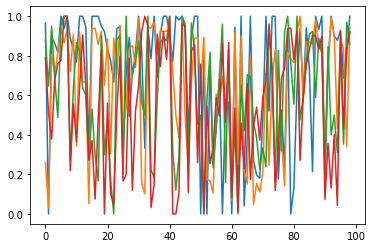

In [113]:
ndmrs, ncelltypes = dmrs_mc.shape
plt.plot(dmrs_mc[1:100,1:5].numpy())

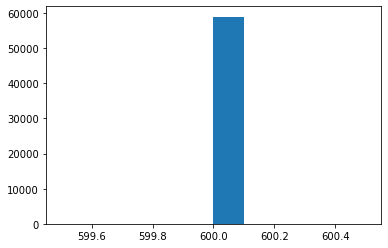

In [55]:
datadir = '/cndd/emukamel/snmCSeq/DMR'
seq_fn = datadir+'/mouse_all_cluster_dms2_HighVariance.600bp.fasta'
seqs = pd.read_csv(seq_fn, index_col = False, header=None, sep="\t")
seq_lengths = [len(i) for i in seqs[1]]
max_seqlength = max(seq_lengths)
plt.hist(seq_lengths);

In [66]:
# One-hot encoding of the sequences
seqs[1] = seqs[1].str.upper()
acgt = 'NACGT'

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))

seqs_1hot = np.zeros(shape=(seqs.shape[0],max_seqlength,len(acgt)), dtype=np.int8) 
for js,seq in enumerate(seqs[1]):
    for jlett,lett in enumerate(seq):
        seqs_1hot[js,jlett,acgt_to_int[lett]] = 1

# Remove the N
seqs_1hot = seqs_1hot[:,:,1:]
acgt = acgt[1:]

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))

In [69]:
# Convert to tensor
seqs_1hot_tensor = torch.tensor(seqs_1hot)

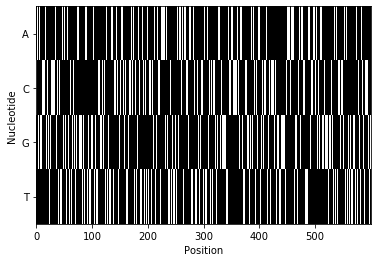

In [70]:
plt.imshow(seqs_1hot[1,:,:].transpose(), aspect='auto', cmap='gray')
plt.ylabel('Nucleotide')
plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
plt.xlabel('Position')
plt.show()

In [100]:
# Define the neural net architecture
window = max_seqlength
nfilt = 128;
filt_width = 7

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(len(acgt), nfilt, filt_width)
        self.pool = nn.MaxPool1d(window-filt_width)
        self.fc1 = nn.Linear(nfilt, nfilt)
        self.fc2 = nn.Linear(nfilt, int(nfilt/2))
        self.fc3 = nn.Linear(int(nfilt/2), ncelltypes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))).squeeze()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
print(torch.cuda.current_device())

cuda:0
0


In [102]:
device

device(type='cuda', index=0)

In [103]:
# # Benchmark how long the training takes. GPU seems to take ~1 s per 1000 items, CPU takes 3 s for batch_size=8. Optimal batch_size=20
# batch_size = 20

# # for log_batch_size in np.arange(3,16):
# #     batch_size = 2**log_batch_size
# for batch_size in np.arange(10,50,2):
#     net = Net()
#     criterion = nn.MSELoss()
#     optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#     if device is not "cpu":
#         net.to(device)
#     net.train
#     running_time = 0
#     X = seqs_1hot_tensor
#     # X = seqs_1hot_tensor[0:1000,:,:]
#     for epoch in range(1):  # loop over the dataset multiple times
#         running_loss = 0.0
#         permutation = torch.randperm(X.size()[0])
#         start=time.time()
#         for i in range(0, X.size()[0], batch_size):
#             indices = permutation[i:i+batch_size]
#             batch_X = X[indices,:,:].float()

#             # Input should be of size: (batch, channels, samples)
#             batch_X = torch.transpose(batch_X,2,1)
#             batch_dmrs_mc = dmrs_mc[indices]

#             # Send training data to CUDA
#             if device is not "cpu":
#                 batch_X = batch_X.to(device)
#                 batch_dmrs_mc = batch_dmrs_mc.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(batch_X)
#             loss = criterion(outputs, batch_dmrs_mc)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             if (time.time()-start)>5:
#                 # print statistics
#                 running_time += time.time()-start
#                 print('[Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
#                       (batch_size, epoch + 1, i, ndmrs, 100*i/ndmrs, running_loss / 2000, 1000*running_time/i))
#                 running_loss = 0.0
#                 start = time.time()
#                 break

# print('Finished Training')

In [189]:
net = Net()
if device is not "cpu":
    net.to(torch.device(device))
criterion = nn.MSELoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

batch_size=20
if device is not "cpu":
    net.to(device)
net.train
running_time = 0
loss_vec = corr_vec = []
nepochs = 0

*** Epoch 385, total loss: 160.857, time=24.081 s


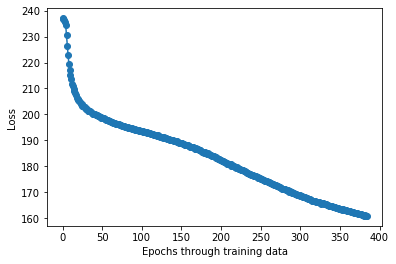

Saved CNN_trained_10-30-19.lr0.010.pickle
  [Batch size 20, Epoch 180, Item 5420/58959, 9.2% of data] loss: 0.0543; 0.370s per 1000 items
  [Batch size 20, Epoch 180, Item 10100/58959, 17.1% of data] loss: 0.0539; 0.397s per 1000 items
  [Batch size 20, Epoch 180, Item 14920/58959, 25.3% of data] loss: 0.0539; 0.403s per 1000 items
  [Batch size 20, Epoch 180, Item 19600/58959, 33.2% of data] loss: 0.0542; 0.409s per 1000 items
  [Batch size 20, Epoch 180, Item 24520/58959, 41.6% of data] loss: 0.0542; 0.409s per 1000 items


In [ ]:
# X = seqs_1hot_tensor
batch_size=20
fn='/cndd/emukamel/CNN_DMR/CNN_trained_'+datetime.datetime.now().strftime('%m-%d-%y')+'.lr%3.3f.save' % lr
X = torch.transpose(seqs_1hot_tensor.float(),2,1).float()
for epoch in range(1000):  # loop over the dataset multiple times
    running_loss = 0.0
    running_time = 0
    permutation = torch.randperm(X.size()[0])
    start=time.time()
    nsamp=0
    for i in range(0, X.size()[0], batch_size):
        indices = permutation[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = X[indices,:,:]
        batch_dmrs_mc = dmrs_mc[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_dmrs_mc)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        nsamp += 1
        if (time.time()-start)>2:
            # print statistics
            running_time += time.time()-start
            print('  [Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
                  (batch_size, epoch + 1, i, ndmrs, 100*i/ndmrs, running_loss/nsamp, 1000*running_time/i))
            start = time.time()
            
    # This is slow....
    #     net.to(torch.device("cpu"))
    #     dmr_hat = net(X).detach().numpy()
    #     r_overall = np.corrcoef(dmrs_mc.cpu().flatten(), dmr_hat.flatten())[0,1]
    #     corr_vec.append(r_overall)

    clear_output()
    print('*** Epoch %d, total loss: %3.6g, time=%3.3f s' %
          (nepochs, running_loss, running_time))

    loss_vec.append(running_loss)

    
    torch.save(net.state_dict(), fn)
    print('Saved %s' % fn)
    
    plt.plot(loss_vec[1:],'o-')
    plt.xlabel('Epochs through training data')
    plt.ylabel('Loss')
    plt.show()
    
    nepochs+=1
print('Finished Training')

In [235]:
# Compare predicted with actual DMR mCG level
X = torch.transpose(seqs_1hot_tensor.float(),2,1)
dmr_hat=np.zeros((ndmrs,ncelltypes))
net.eval()
net.to(torch.device("cpu"))
start = time.time()
dmr_hat = net(X).detach().numpy()
print('Done; %fs' % (time.time()-start))

Done; 7.750818s


Mean correlation r=0.484±0.070; overall r=0.563


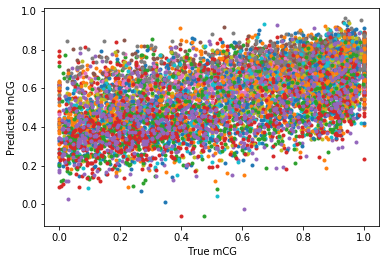

In [236]:
r_cell = np.zeros((ncelltypes,1))
for celltype in range(ncelltypes):
    cc = np.corrcoef(dmrs_mc.cpu()[:,celltype], dmr_hat[:,celltype])
    r_cell[celltype] = cc[0,1]
r_overall = np.corrcoef(dmrs_mc.cpu().flatten(), dmr_hat.flatten())[0,1]
print('Mean correlation r=%.3f±%3.3f; overall r=%.3f' % (np.mean(r_cell),np.std(r_cell), r_overall))

plt.plot(dmrs_mc.cpu()[::100,:], dmr_hat[::100,:], '.');
plt.xlabel('True mCG');
plt.ylabel('Predicted mCG')
plt.show()

In [237]:
print(np.max(weights), np.min(weights))

0.3892601 -0.28194395


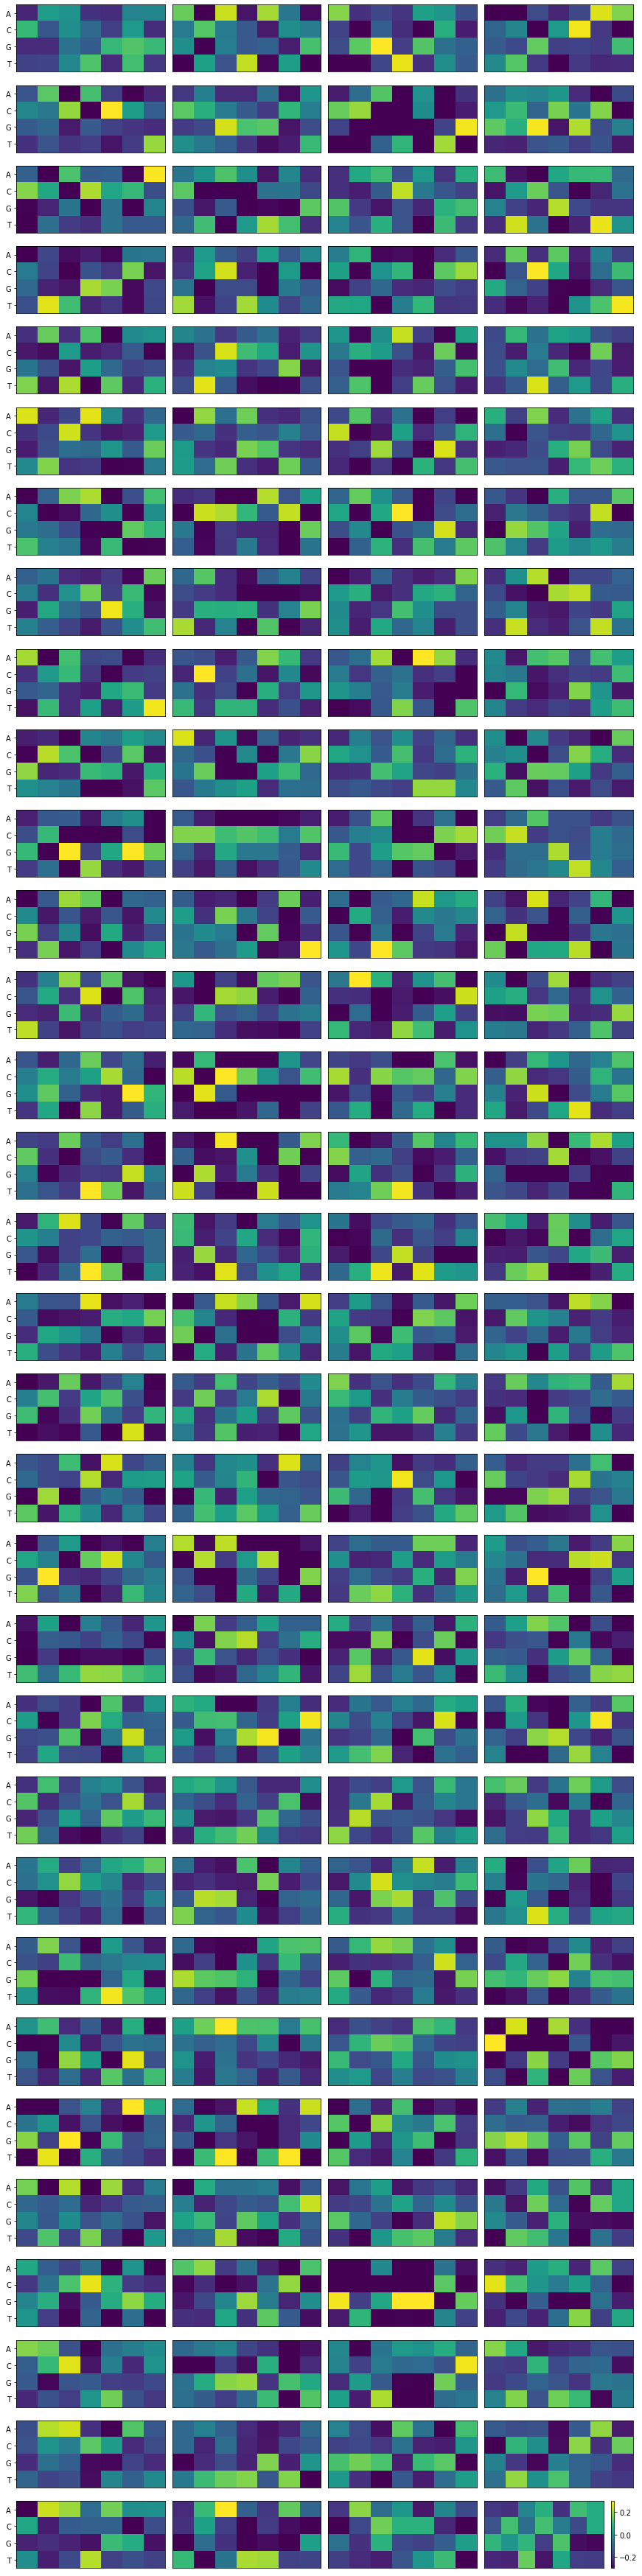

In [238]:
# Visualize the weight matrices
weights = net.state_dict()['conv1.weight'].numpy()
plt.figure(figsize=(15,2*128/4))

for jfeature in range(weights.shape[0]):
    plt.subplot(128/4,4,jfeature+1,xmargin=-0.4)
    weight = weights[jfeature,:,:].squeeze()
    plt.imshow(weight, aspect='auto', vmin=-.3,vmax=.3)
    plt.xticks([])
    if (jfeature % 4 ==0):
        plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
    else:
        plt.yticks([])
#     if jfeature>5:
#         break

plt.subplots_adjust(wspace=0.05)
plt.colorbar();
# plt.show()

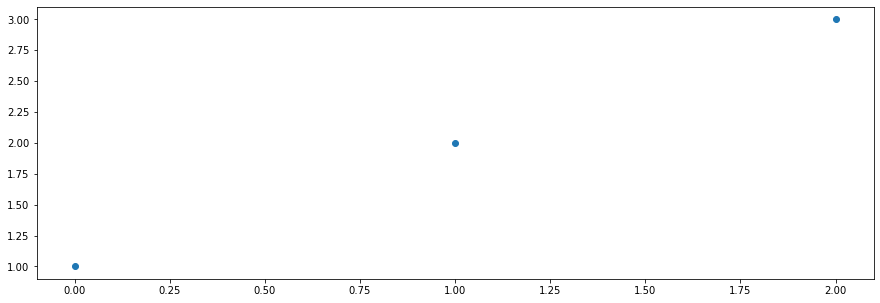

In [30]:
plt.figure(figsize=(15,5))
plt.plot([1,2,3],'o')

In [ ]:
PATH = './CNN_dmrs.state'
torch.save(net.state_dict(), PATH)

In [95]:
plt.figure(figsize=(128/4,4))


<Figure size 2304x288 with 0 Axes>

<Figure size 2304x288 with 0 Axes>